In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve

np.random.seed(0)

In [11]:
# Load the datasets
patients_df = pd.read_csv('cleaned_PATIENTS.csv')
admissions_df = pd.read_csv('cleaned_ADMISSIONS.csv')

In [12]:
patients_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13,NaN,NaN,NaN,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15,NaN,NaN,NaN,0
3,237,252,M,2078-03-06,NaN,NaN,NaN,0
4,238,253,F,2089-11-26,NaN,NaN,NaN,0


In [13]:
admissions_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_LOCATION,DISCHARGE_LOCATION,EDREGTIME,EDOUTTIME,...,ETHNICITY_PATIENT DECLINED TO ANSWER,ETHNICITY_PORTUGUESE,ETHNICITY_SOUTH AMERICAN,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ETHNICITY_WHITE - BRAZILIAN,ETHNICITY_WHITE - EASTERN EUROPEAN,ETHNICITY_WHITE - OTHER EUROPEAN,ETHNICITY_WHITE - RUSSIAN
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,2196-04-09 10:06:00,2196-04-09 13:24:00,...,False,False,False,False,False,True,False,False,False,False
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,NaN,NaN,...,False,False,False,False,False,True,False,False,False,False
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,NaN,NaN,...,False,False,False,False,False,True,False,False,False,False
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,TRANSFER FROM HOSP/EXTRAM,HOME,NaN,NaN,...,False,False,False,False,False,True,False,False,False,False
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY ROOM ADMIT,HOME,2160-11-02 01:01:00,2160-11-02 04:27:00,...,False,False,False,False,False,True,False,False,False,False


# Merge + Clean data

In [14]:
# Pick either HOSPITAL_EXPIRE_FLAG or EXPIRE_FLAG
death_variable = "EXPIRE_FLAG"

In [15]:
# For merging, select only the first occurrence since the aim is to avoid multiple entries but keep one-hot encoding
first_admissions_entry = admissions_df.groupby('SUBJECT_ID').head(1)

# Merging the first entry of admissions data with the patients data

# USE THIS FOR EXPIRE_FLAG
merged_df = pd.merge(patients_df[['SUBJECT_ID', death_variable]], first_admissions_entry, on='SUBJECT_ID')

# USE THIS FOR HOSPITAL_EXPIRE_FLAG
# merged_df = pd.merge(patients_df[['SUBJECT_ID']], first_admissions_entry, on='SUBJECT_ID')

merged_df.head()

,SUBJECT_ID,EXPIRE_FLAG,ROW_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_LOCATION,DISCHARGE_LOCATION,EDREGTIME,...,ETHNICITY_PATIENT DECLINED TO ANSWER,ETHNICITY_PORTUGUESE,ETHNICITY_SOUTH AMERICAN,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ETHNICITY_WHITE - BRAZILIAN,ETHNICITY_WHITE - EASTERN EUROPEAN,ETHNICITY_WHITE - OTHER EUROPEAN,ETHNICITY_WHITE - RUSSIAN
0,249,0,321,116935,2149-12-17 20:41:00,2149-12-31 14:55:00,NaN,EMERGENCY ROOM ADMIT,SNF,2149-12-17 11:10:00,...,False,False,False,False,False,True,False,False,False,False
1,250,1,324,124271,2188-11-12 09:22:00,2188-11-22 12:00:00,2188-11-22 12:00:00,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,2188-11-12 06:56:00,...,False,False,False,False,False,False,False,False,False,False
2,251,0,325,117937,2110-07-27 06:46:00,2110-07-29 15:23:00,NaN,EMERGENCY ROOM ADMIT,HOME,2110-07-27 05:00:00,...,False,False,False,False,True,False,False,False,False,False
3,252,0,326,190159,2133-03-31 04:24:00,2133-04-23 15:00:00,NaN,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,2133-03-31 03:58:00,...,False,False,False,False,False,True,False,False,False,False
4,253,0,328,176189,2174-01-21 20:58:00,2174-01-26 16:15:00,NaN,TRANSFER FROM HOSP/EXTRAM,SNF,NaN,...,False,False,False,False,False,True,False,False,False,False


### Check for the number of patients that do not have a consistent demographic values (ethnicity, language, religion) across each hospital admission

In [16]:
# Identifying one-hot encoded columns for each category
ethnicity_cols = [col for col in admissions_df.columns if col.startswith('ETHNICITY_')]
religion_cols = [col for col in admissions_df.columns if col.startswith('RELIGION_')]
language_cols = [col for col in admissions_df.columns if col.startswith('LANGUAGE_')]

# To check for changes in one-hot encoded columns, we sum across rows for each category in the original admissions_df_new
# This will give a count of how many times each category was marked for each patient
sum_ethnicity = admissions_df.groupby('SUBJECT_ID')[ethnicity_cols].sum()
sum_religion = admissions_df.groupby('SUBJECT_ID')[religion_cols].sum()
sum_language = admissions_df.groupby('SUBJECT_ID')[language_cols].sum()

# A patient has changed their info if the sum in any category column is > 1
changes_ethnicity = sum_ethnicity[sum_ethnicity > 1].dropna(how='all')
changes_religion = sum_religion[sum_religion > 1].dropna(how='all')
changes_language = sum_language[sum_language > 1].dropna(how='all')

# Number of patients with changes
num_changes = {
    'Ethnicity Changes': changes_ethnicity.shape[0],
    'Religion Changes': changes_religion.shape[0],
    'Language Changes': changes_language.shape[0]
}

num_changes

{'Ethnicity Changes': 7371, 'Religion Changes': 7426, 'Language Changes': 4898}

### Drop those patients that have inconsistent demographic values

In [17]:
# Create a boolean mask of patients who haven't changed any categorical variable
no_changes_mask = ~merged_df['SUBJECT_ID'].isin(
    changes_ethnicity.index.union(changes_religion.index).union(changes_language.index)
)

# Create a new dataframe with only the patients who haven't changed their categorical variables
merged_df = merged_df[no_changes_mask]
merged_df.head()

,SUBJECT_ID,EXPIRE_FLAG,ROW_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_LOCATION,DISCHARGE_LOCATION,EDREGTIME,...,ETHNICITY_PATIENT DECLINED TO ANSWER,ETHNICITY_PORTUGUESE,ETHNICITY_SOUTH AMERICAN,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ETHNICITY_WHITE - BRAZILIAN,ETHNICITY_WHITE - EASTERN EUROPEAN,ETHNICITY_WHITE - OTHER EUROPEAN,ETHNICITY_WHITE - RUSSIAN
1,250,1,324,124271,2188-11-12 09:22:00,2188-11-22 12:00:00,2188-11-22 12:00:00,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,2188-11-12 06:56:00,...,False,False,False,False,False,False,False,False,False,False
2,251,0,325,117937,2110-07-27 06:46:00,2110-07-29 15:23:00,NaN,EMERGENCY ROOM ADMIT,HOME,2110-07-27 05:00:00,...,False,False,False,False,True,False,False,False,False,False
4,253,0,328,176189,2174-01-21 20:58:00,2174-01-26 16:15:00,NaN,TRANSFER FROM HOSP/EXTRAM,SNF,NaN,...,False,False,False,False,False,True,False,False,False,False
5,255,0,329,112013,2187-02-12 10:30:00,2187-02-15 10:30:00,NaN,PHYS REFERRAL/NORMAL DELI,HOME,NaN,...,False,False,False,False,False,True,False,False,False,False
7,257,1,334,179006,2112-12-20 20:45:00,2112-12-23 17:00:00,NaN,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,2112-12-20 14:35:00,...,False,False,False,False,False,True,False,False,False,False


In [18]:
# merged df now only has patients that did not change their categorical variables within multiple admissions to the hospital. 
merged_df.shape

(38999, 163)

In [19]:
merged_df.isna().sum()

SUBJECT_ID                            0
EXPIRE_FLAG                           0
ROW_ID                                0
HADM_ID                               0
ADMITTIME                             0
                                     ..
ETHNICITY_WHITE                       0
ETHNICITY_WHITE - BRAZILIAN           0
ETHNICITY_WHITE - EASTERN EUROPEAN    0
ETHNICITY_WHITE - OTHER EUROPEAN      0
ETHNICITY_WHITE - RUSSIAN             0
Length: 163, dtype: int64

In [20]:
ethnicity_columns = [col for col in merged_df.columns if 'ETHNICITY_' in col]
religion_columns = [col for col in merged_df.columns if 'RELIGION_' in col]
language_columns = [col for col in merged_df.columns if 'LANGUAGE_' in col]

## Bar graph for counting total patients and deaths in each demographic category 

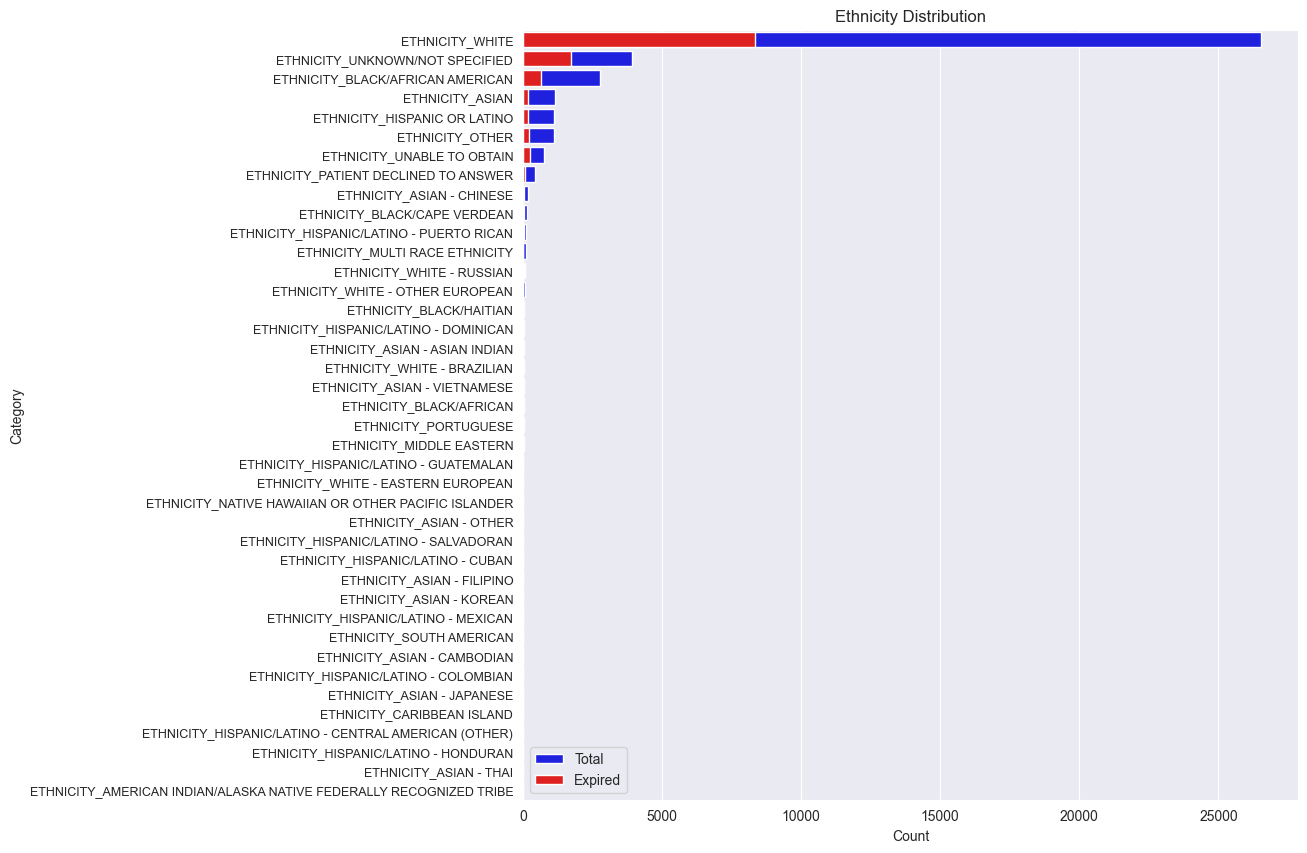

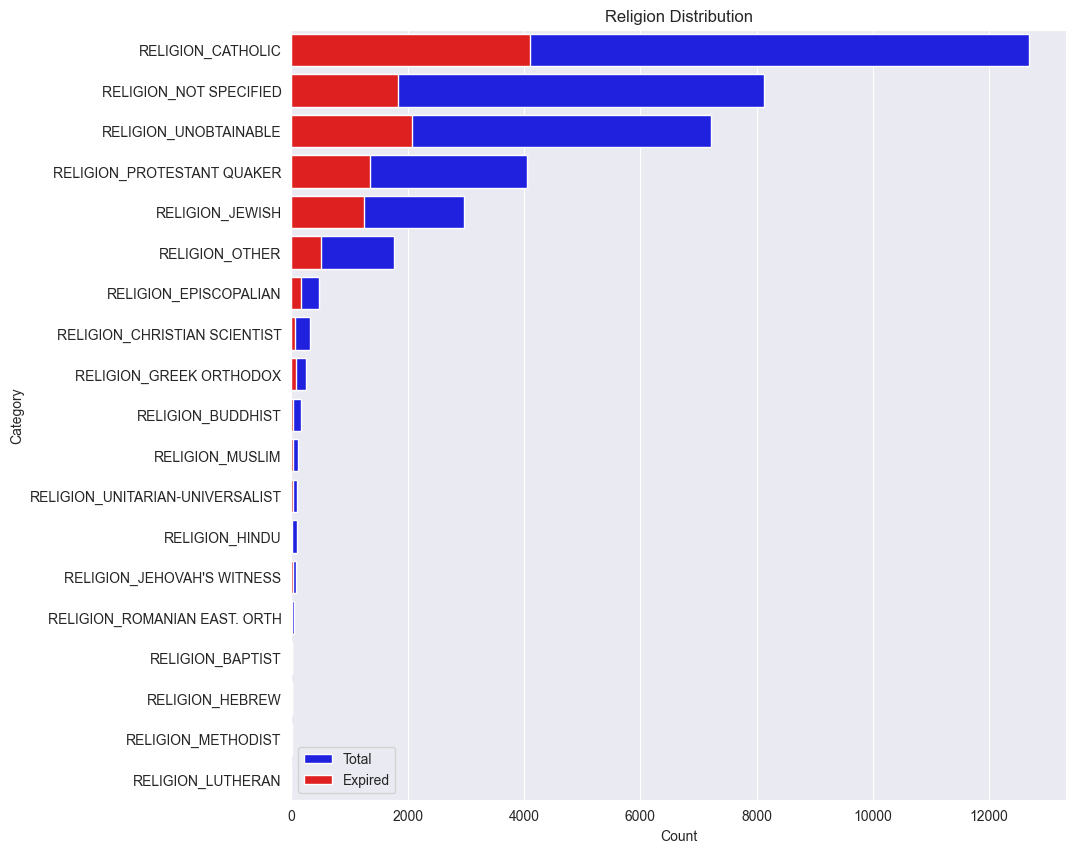

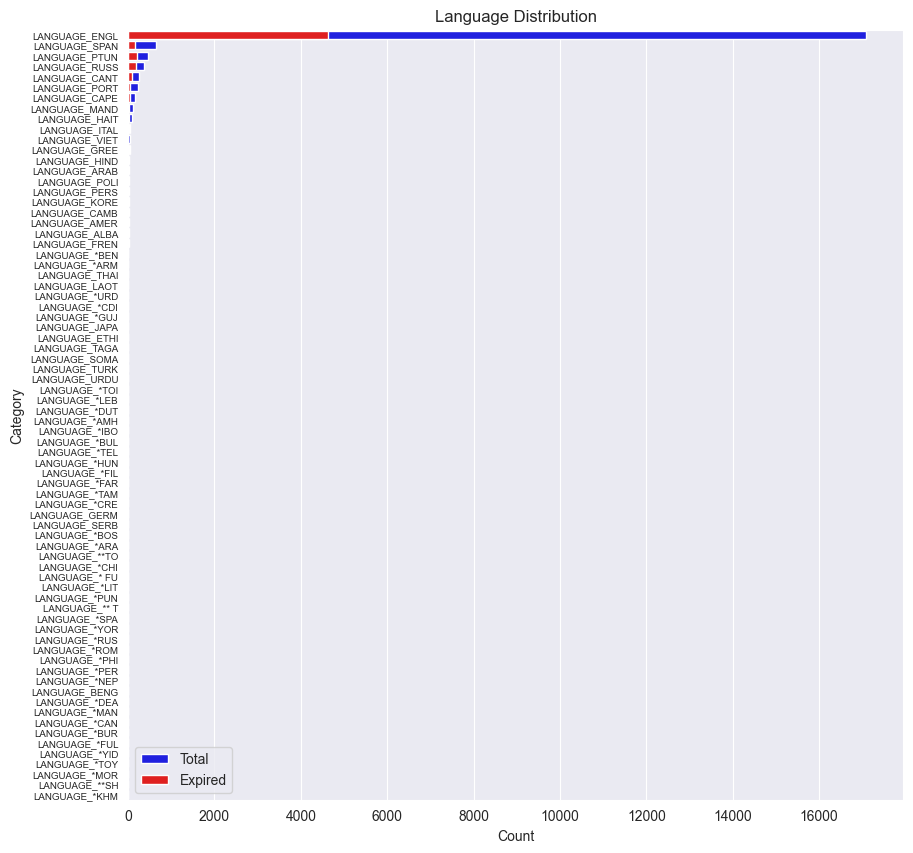

In [21]:
def plot_demographic_distribution_with_expiry(columns, title, font_size):
    # Calculating total counts for each demographic category
    total_demographic_counts = merged_df[columns].sum().sort_values(ascending=False)
    
    # Calculating counts of expired for each demographic category
    expired_demographic_counts = merged_df[merged_df[death_variable] == 1][columns].sum().sort_values(ascending=False)

    # Ensure the order of 'expired' counts matches the 'total' counts
    expired_demographic_counts = expired_demographic_counts.reindex(total_demographic_counts.index)
    
    # Plot
    plt.figure(figsize=(10, 10))
    # Plotting total counts
    sns.barplot(x=total_demographic_counts.values, y=total_demographic_counts.index, color="blue", label="Total")
    # Plotting expired counts on top of total counts
    sns.barplot(x=expired_demographic_counts.values, y=expired_demographic_counts.index, color="red", label="Expired")
    
    plt.title(title)
    plt.xlabel('Count')
    plt.yticks(fontsize=font_size) 
    plt.ylabel('Category')
    plt.legend()
    plt.show()

plot_demographic_distribution_with_expiry(ethnicity_columns, 'Ethnicity Distribution', 9)
plot_demographic_distribution_with_expiry(religion_columns, 'Religion Distribution', 10)
plot_demographic_distribution_with_expiry(language_columns, 'Language Distribution', 7)

### Similar to above bar graph but now x-axis is log scale

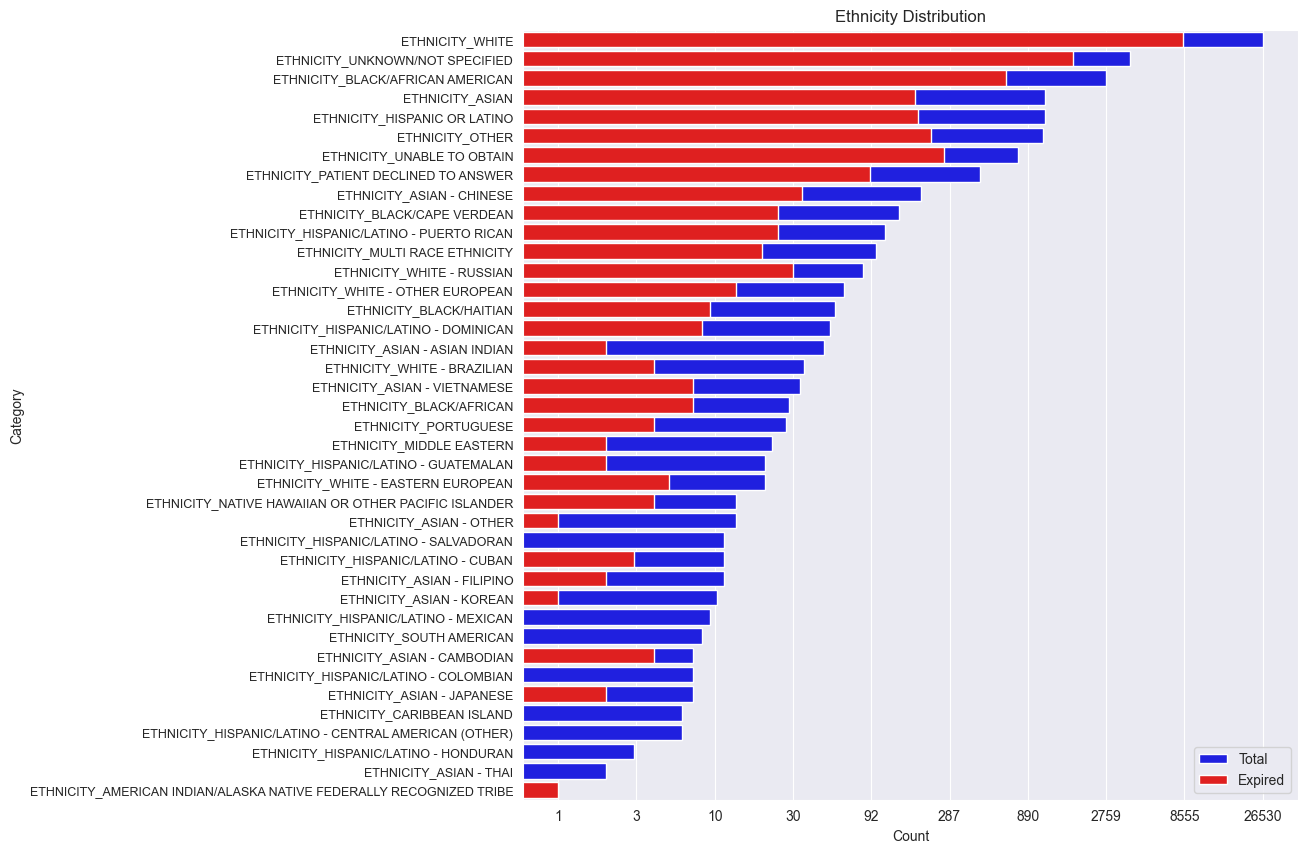

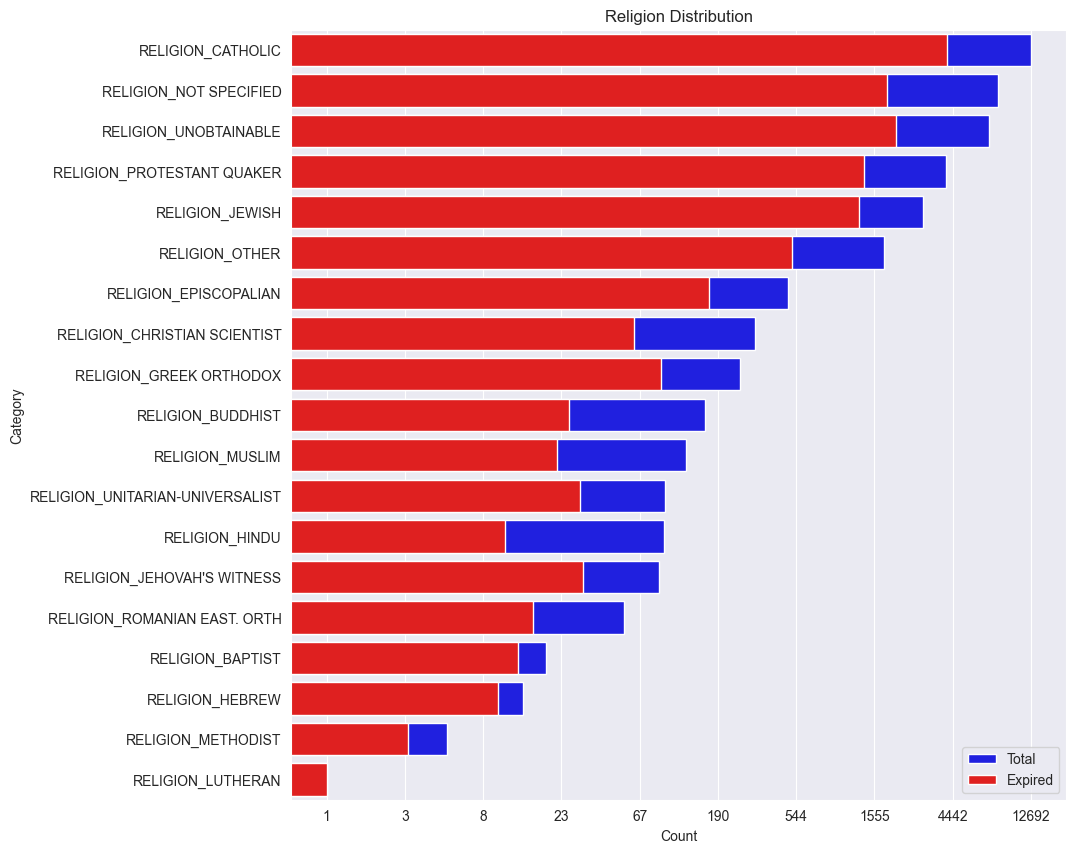

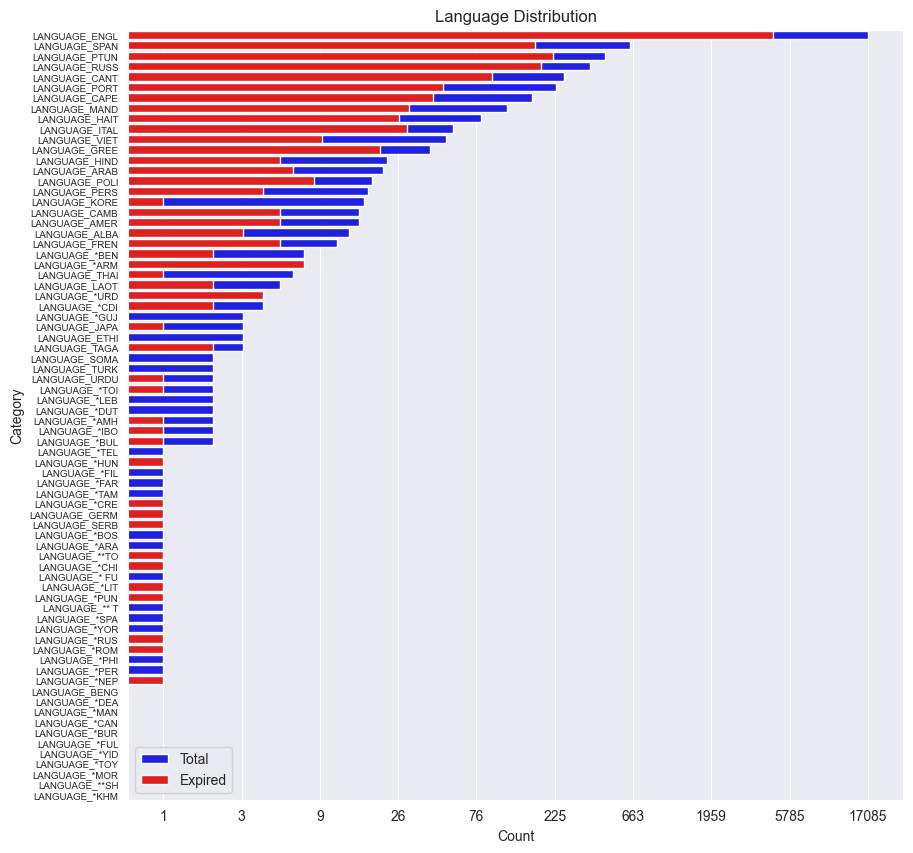

In [22]:
def plot_demographic_distribution_with_expiry(columns, title, font_size):
    # Calculating total counts for each demographic category
    total_demographic_counts = merged_df[columns].sum().sort_values(ascending=False)
    
    # Calculating counts of expired for each demographic category
    expired_demographic_counts = merged_df[merged_df[death_variable] == 1][columns].sum().sort_values(ascending=False)

    # Ensure the order of 'expired' counts matches the 'total' counts
    expired_demographic_counts = expired_demographic_counts.reindex(total_demographic_counts.index)
    
    # Adjusting for zero or negative values that can't be plotted on a log scale
    total_demographic_counts = total_demographic_counts.replace(0, np.nan)
    expired_demographic_counts = expired_demographic_counts.replace(0, np.nan)
    
    # Plot
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(1, 1, 1)
    
    # Plotting total counts
    sns.barplot(x=total_demographic_counts.values, y=total_demographic_counts.index, color="blue", label="Total")
    # Plotting expired counts on top of total counts
    sns.barplot(x=expired_demographic_counts.values, y=expired_demographic_counts.index, color="red", label="Expired")
    
    plt.title(title)
    plt.xlabel('Count')
    plt.yticks(fontsize=font_size)
    plt.ylabel('Category')
    plt.legend()
    
    # Set the x-axis to a log scale
    ax.set_xscale('log')
    
    # Handling tick marks for log scale with possible NaN or inf values
    valid_values = total_demographic_counts.dropna().values
    if len(valid_values) > 0:
        min_val = np.min(valid_values[valid_values > 0])
        max_val = np.max(valid_values)
        tick_values = np.logspace(np.log10(min_val), np.log10(max_val), num=10)
        ax.set_xticks(tick_values)
        ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    
    plt.show()


plot_demographic_distribution_with_expiry(ethnicity_columns, 'Ethnicity Distribution', 9)
plot_demographic_distribution_with_expiry(religion_columns, 'Religion Distribution', 10)
plot_demographic_distribution_with_expiry(language_columns, 'Language Distribution', 7)

Please note that some population of a categorical group all expired. This means all Beth Israel Deaconess Medical Center patients that has that specific demographic value has passed away.
Following graph will be about mortality rate which is number of deaths of a specific population / total specific population. There can be some graphs that have 100%. 

## Bar graphs for mortality rate within their respective category

In [ ]:
def plot_mortality_rates_corrected(columns, title):
    mortality_rates = {}
    for col in columns:
        group_mean = merged_df.groupby(col)[death_variable].mean()
        if len(group_mean) > 1:  # Ensure there are at least two groups (0 and 1 for the demographic variable)
            mortality_rate = group_mean.loc[True] * 100  # Specifically use .loc[True] to avoid indexing issues
        else:
            mortality_rate = 0  # Default to 0 if there's no variation in the group
        mortality_rates[col] = mortality_rate
    
    # Sorting the mortality rates for plotting
    mortality_rates_sorted = {k: v for k, v in sorted(mortality_rates.items(), key=lambda item: item[1], reverse=True)}
    
    # Creating the plot
    plt.figure(figsize=(9, 20))
    sns.barplot(x=list(mortality_rates_sorted.values()), y=list(mortality_rates_sorted.keys()), color="salmon")
    plt.title(f'Mortality Rates by {title}')
    plt.xlabel('Mortality Rate (%)')
    plt.ylabel('Category')
    plt.show()


# Each bar represents the mortality rate (%) within the respective category.
plot_mortality_rates_corrected(ethnicity_columns, 'Ethnicity') 
plot_mortality_rates_corrected(religion_columns, 'Religion')
plot_mortality_rates_corrected(language_columns, 'Language')

In [ ]:
merged_df.head()

# chi-square test 
For each categorical variable (e.g., ethnicity, religion, language), a contingency table is created comparing the counts of outcomes (in this case, mortality indicated by death_variable) across the categories of that variable. This table provides a summary of the observed frequencies of mortality (alive or deceased) within each group. `table = pd.crosstab(merged_df[col], merged_df[death_variable])`

The chi-square test calculates a statistic that measures the difference between the observed frequencies in each category and the frequencies that would be expected if there was no association between the categorical variable and mortality. The formula for the chi-square statistic involves summing the squared difference between observed and expected frequencies, divided by the expected frequencies: $\Chi ^2 = \Sigma\frac{(O-E)^2}{E}$


## Interpreting it

Chi-square statistic $(\Chi ^2)$: A higher value indicates a greater difference between observed and expected frequencies, suggesting a stronger association between the categorical variable and mortality rates.
 
A lower p-value (typically less than 0.05) is interpreted as evidence against the null hypothesis (which posits no association), indicating a statistically significant difference in mortality rates across the groups.

In [ ]:
# Function to perform chi-square tests for a list of columns
def chi_square_test_for_columns(columns):
    results = {}
    for col in columns:
        # Create a contingency table
        table = pd.crosstab(merged_df[col], merged_df[death_variable])
        # Perform the chi-square test
        chi2, p, dof, expected = chi2_contingency(table)
        # Store the results
        results[col] = p
    return results

ethnicity_results = chi_square_test_for_columns(ethnicity_columns) 
religion_results = chi_square_test_for_columns(religion_columns) 
language_results = chi_square_test_for_columns(language_columns) 

ethnicity_results, religion_results, language_results

In [ ]:
# Combine the results into a single dictionary for easier plotting
chi_square_results = {
    **ethnicity_results,
    **religion_results,
    **language_results
}

# Transform the p-values using negative logarithm to emphasize differences
# Add a small value to avoid taking log(0) which is undefined
log_p_values = {k: -np.log10(v + 1e-100) for k, v in chi_square_results.items()}

# Sorting results for better visualization
sorted_categories = sorted(log_p_values.keys(), key=lambda x: log_p_values[x], reverse=True)

# Plotting
plt.figure(figsize=(10, 20))
plt.barh(sorted_categories, [log_p_values[category] for category in sorted_categories], color='skyblue')
plt.xlabel('-Log10(p-value)')
plt.ylabel('Categories')
plt.yticks(fontsize=7)

plt.title('Chi-square Test Results (Negative Log10 of p-values)')
plt.axvline(x=-np.log10(0.05), color='red', linestyle='--', label='p=0.05 Significance Level')
plt.legend()
plt.show()

In [ ]:
# Function to filter and print categories with significant differences (p < 0.05)
def print_significant_categories(result_dict, category_name):
    significant_categories = {k: v for k, v in result_dict.items() if v < 0.05}
    if significant_categories:
        print(f"Significant {category_name} categories:")
        for category, p_value in significant_categories.items():
            print(f"- {category}: p-value = {p_value}")
    else:
        print(f"No significant {category_name} categories found.")

# Print significant categories for ethnicity, religion, and language
print_significant_categories(ethnicity_results, "ethnicity")
print_significant_categories(religion_results, "religion")
print_significant_categories(language_results, "language")

In [ ]:
merged_df.columns.to_list()

# Logistic regression

In [ ]:
# Dropping non-numeric and irrelevant columns
df_numeric = merged_df.drop(['SUBJECT_ID',
 'ROW_ID',
 'HADM_ID',
 'ADMITTIME',
 'DISCHTIME',
 'DEATHTIME',
 'ADMISSION_LOCATION',
 'DISCHARGE_LOCATION',
 'EDREGTIME',
 'EDOUTTIME',
 'DIAGNOSIS',
 'HOSPITAL_EXPIRE_FLAG',
 'HAS_CHARTEVENTS_DATA',
 'DOB',
 'AGE_AT_ADMIT',
 'AGE_AT_DEATH',
 'ADMISSION_TYPE_EMERGENCY',
 'ADMISSION_TYPE_NEWBORN',
 'ADMISSION_TYPE_URGENT',
 'INSURANCE_Medicaid',
 'INSURANCE_Medicare',
 'INSURANCE_Private',
 'INSURANCE_Self Pay',], axis=1)

# Splitting the dataset into features (X) and target (y)
X = df_numeric.drop(death_variable, axis=1)
y = df_numeric[death_variable]

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

In [ ]:
# Predictions and evaluation
predictions = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(classification_report(y_test, predictions))

# Coefficients
# Transforming coefficients to odds ratios for interpretation
odds_ratios = pd.DataFrame(data=np.exp(model.coef_[0]), index=X.columns, columns=['Odds Ratio'])
print(odds_ratios)
# odds_ratios.head().sort_values('Odds Ratio', ascending=False)

#### Accuracy Score
Accuracy (0.69 or 69%): This is the proportion of all predictions (for both classes 0 and 1) that were correct. In your model, 69% of the predictions matched the actual values. 

#### Classification Report

Precision: The ratio of true positive predictions to the total predicted positives. Precision for class 0 is 0.71, meaning that when the model predicts a patient did not expire, it is correct 71% of the time. For class 1, it's 0.60.

Recall (Sensitivity): The ratio of true positive predictions to the actual positives in the data. For class 0, the recall is 0.90, indicating the model is very good at identifying the non-expire cases. For class 1, the recall is only 0.29, showing the model struggles to identify all true expire cases.

F1-Score: The harmonic mean of precision and recall, giving a single score that balances the two. For class 0, it's 0.79, and for class 1, it's 0.39. 

Support: The actual number of occurrences of each class in the dataset. Class 0 (non-expire) had 6122 instances, and class 1 (expire) had 3182.

#### Odds Ratios
Odds ratios indicate the change in odds resulting from a one-unit increase in the predictor variable, holding all other variables constant. An odds ratio:

1 indicates an increase in the odds of the outcome (in this case, mortality) for a one-unit increase in the predictor.

< 1 indicates a decrease in the odds of the outcome for a one-unit increase in the predictor.

= 1 suggests no effect on the odds.

Examples:
LANGUAGE_SH (Odds Ratio 1.848929): Patients with this language attribute have about 1.85 times the odds of the outcome (mortality) compared to patients without this attribute.

ETHNICITY_WHITE - BRAZILIAN (Odds Ratio 0.629924): This suggests being categorized as white Brazilian decreases the odds of the outcome (mortality) by about 37% ([1 - 0.629924] * 100) compared to the reference category.

In [ ]:
# Predicting probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Calculating the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc}")

# Calculating ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

These interpretations help show which variables are most strongly associated with the outcome, and in what direction. However, it's important to remember that association does not imply causation, and these relationships can be influenced by the presence of other variables.